In [4]:
pwd

'/Users/cl1704/PycharmProjects/object_manipulation/FingerReach/Notebooks'

In [1]:
import myosuite
import gym
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns
N_EPISODES = 1000
from mujoco import viewer


from stable_baselines3 import DDPG
env = gym.make('myoHandReachFixed-v0')

MyoSuite:> Registering Myo Envs


/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/dm_control_compatibility.py", line 16, in <module>
    from dm_control import composer
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/dm_control/composer/__init__.py

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


In [2]:
import torch.nn as nn

class WorldNet(nn.Module):
    def __init__(self,state_dim,action_dim,target_dim):
        super(WorldNet, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.target_dim = target_dim
        # Take state and action and ouput new state
        self.f = torch.nn.Sequential(nn.Linear(self.state_dim + self.action_dim,16,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(16,32,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(32,64,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(64,128,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(128,64,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(64,32,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(32,16,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(16,8,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(8,self.state_dim,bias=True),
                                  )
        self.mlp_reward = nn.Linear(self.state_dim,self.target_dim,bias=True)
    def forward(self, u):
        # Initial state (position and velocity)
        x = torch.zeros(u.shape[0],u.shape[1]+1,115)
        x[:,0,:] = u[:,0,:115]
        for t in range(1,u.shape[1]+1):
            x[:,t,:] = x[:,t-1,:] + self.f(torch.hstack([x[:,t-1,:],u[:,t-1,-39:]]))
            
        #state_prediction = self.mlp_state(x)
        reward_prediction = -torch.sqrt(torch.sum(self.mlp_reward(x[:,1:,:])**2,dim=2,keepdim=True))
   
        return torch.concatenate([x[:,:-1,:], reward_prediction],dim=2)
    

In [7]:
# GENERATE TRAINING DATASET FOR WORLD MODEL
NUM_EPISODES = 1000
MAX_STEPS = 100
ACTION_DIM = 39
STATE_DIM = 115
TARGET_DIM = 15
# Loop over episodes
SHIFT = 0
inputs = torch.zeros(NUM_EPISODES,MAX_STEPS-SHIFT,STATE_DIM + ACTION_DIM)
labels = torch.zeros(NUM_EPISODES,MAX_STEPS-SHIFT,STATE_DIM + 1)

for episode in range(NUM_EPISODES):
    # Reset environment
    state = env.reset()
    action = np.array(torch.normal(mean=.2, std=0.1,size=[ACTION_DIM]))

    for step in range(MAX_STEPS):
        # Take step in environment to get new state and reward
        new_state, reward, _, _ = env.step(action)
        # Add data 
        if step>=SHIFT:
            inputs[episode,step-SHIFT ,:] = torch.tensor(np.hstack([state,action])).float()
            labels[episode,step-SHIFT,:] = torch.tensor(np.hstack([state,reward])).float()
        # Set current state to new state
        state = new_state
# z-score


In [5]:
world_network  = torch.load('world_network.pth',map_location='cpu',weights_only=False)

In [8]:
#world_network = WorldNet(state_dim=STATE_DIM,action_dim=ACTION_DIM,target_dim=TARGET_DIM)
world_network  = torch.load('world_network.pth')

#world_network.train()
# Initialize optimizer and wrap training data as PyTorch dataset
optimizer = torch.optim.Adam(world_network.parameters(), lr=.0002,weight_decay = 0)
my_dataset = TensorDataset(inputs, labels)  #
my_dataloader = DataLoader(my_dataset, batch_size=256,shuffle=True)

NUM_EPOCHS = 10000
# Training loop
loss_history = []

for i in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_idx, (u_batch, z_batch) in enumerate(my_dataloader):
        optimizer.zero_grad()
        x_batch = world_network.forward(u_batch)
        z_batch_centered  = (z_batch - torch.mean(z_batch,dim=[0,1],keepdim=True))/torch.std(z_batch,dim=[0,1],keepdim=True)
        x_batch_centered = (x_batch - torch.mean(x_batch,dim=[0,1],keepdim=True))/torch.std(x_batch,dim=[0,1],keepdim=True)
        loss = torch.nn.MSELoss()(x_batch_centered, z_batch_centered) 
        epoch_loss += loss.item() / NUM_EPOCHS
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(world_network.parameters(), max_norm=.1)

        optimizer.step()

    if i % 50 == 0:
        outputs = world_network.forward(inputs)
        print('Epoch: {}/{}.............'.format(i, NUM_EPOCHS), end=' ')
        labels_centered  = labels - torch.mean(labels,dim=1,keepdim=True)
        print("mse_z: {:.8f}".format(torch.nn.MSELoss()(outputs,labels).item()/ torch.nn.MSELoss()(torch.zeros_like(labels_centered), labels_centered).item()))
        torch.save(world_network,'world_network.pth')
        loss_history.append(epoch_loss) 


Epoch: 0/10000............. mse_z: 80.36442852
Epoch: 50/10000............. mse_z: 70.11757457
Epoch: 100/10000............. mse_z: 69.01154312
Epoch: 150/10000............. mse_z: 65.73849052
Epoch: 200/10000............. mse_z: 63.89451690
Epoch: 250/10000............. mse_z: 61.24970627
Epoch: 300/10000............. mse_z: 59.71903303
Epoch: 350/10000............. mse_z: 56.36169965
Epoch: 400/10000............. mse_z: 55.40439047
Epoch: 450/10000............. mse_z: 53.56180216
Epoch: 500/10000............. mse_z: 52.02112026
Epoch: 550/10000............. mse_z: 51.49554628
Epoch: 600/10000............. mse_z: 51.25301861
Epoch: 650/10000............. mse_z: 51.47151216
Epoch: 700/10000............. mse_z: 49.46706070
Epoch: 750/10000............. mse_z: 48.29238735
Epoch: 800/10000............. mse_z: 47.65640661
Epoch: 850/10000............. mse_z: 46.54881740
Epoch: 900/10000............. mse_z: 45.61445469
Epoch: 950/10000............. mse_z: 44.49203887
Epoch: 1000/10000......

In [8]:
# VISUALIZE WORLD MODEL
outputs = world_network.forward(inputs)
z = labels
outputs  = (outputs - torch.mean(outputs,dim=[0,1],keepdim=True))/torch.std(outputs,dim=[0,1],keepdim=True)
z = (z - torch.mean(z,dim=[0,1],keepdim=True))/torch.std(z,dim=[0,1],keepdim=True)
rows = []
for episode in range(inputs.shape[0]):
    for step in range(inputs.shape[1]):
        # Finger 1
        rows.append({'episode':episode,
                     'step': step,
                     'finger':1,
                    'x':z[episode,step,46].item(),
                     'y':z[episode,step,47].item(),
                     'z':z[episode,step,48].item(),
                     'x_pred':outputs[episode,step,46].item(),
                     'y_pred':outputs[episode,step,47].item(),
                     'z_pred':outputs[episode,step,48].item()})
        # Finger 2
        rows.append({'episode':episode,
                     'step': step,
                     'finger':2,
                    'x':z[episode,step,49].item(),
                     'y':z[episode,step,50].item(),
                     'z':z[episode,step,51].item(),
                     'x_pred':outputs[episode,step,49].item(),
                     'y_pred':outputs[episode,step,50].item(),
                     'z_pred':outputs[episode,step,51].item()})
        # Finger 3
        rows.append({'episode':episode,
                     'step': step,
                     'finger':3,
                    'x':z[episode,step,52].item(),
                     'y':z[episode,step,53].item(),
                     'z':z[episode,step,54].item(),
                     'x_pred':outputs[episode,step,52].item(),
                     'y_pred':outputs[episode,step,53].item(),
                     'z_pred':outputs[episode,step,54].item()})
        # Finger 4
        rows.append({'episode':episode,
                     'step': step,
                     'finger':4,
                    'x':z[episode,step,55].item(),
                     'y':z[episode,step,56].item(),
                     'z':z[episode,step,57].item(),
                     'x_pred':outputs[episode,step,55].item(),
                     'y_pred':outputs[episode,step,56].item(),
                     'z_pred':outputs[episode,step,57].item()})
        
        # Finger 5
        rows.append({'episode':episode,
                     'step': step,
                     'finger':5,
                    'x':z[episode,step,58].item(),
                     'y':z[episode,step,59].item(),
                     'z':z[episode,step,60].item(),
                     'x_pred':outputs[episode,step,58].item(),
                     'y_pred':outputs[episode,step,59].item(),
                     'z_pred':outputs[episode,step,60].item()})
df = pd.DataFrame(rows)

/var/folders/9_/yjc4d8zx4tj6kw6h4xgj4zd80000gn/T/ipykernel_77057/1616763373.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df[df.episode==episode], x = 'x', y = 'y',ax=ax,edgecolor=None,alpha=.5,s=4,palette = sns.husl_palette(n_colors = 5),size = 'step')
/var/folders/9_/yjc4d8zx4tj6kw6h4xgj4zd80000gn/T/ipykernel_77057/1616763373.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df[df.episode==episode], x = 'x_pred', y = 'y_pred',ax=ax,edgecolor=None,alpha=.5,s=4,palette = sns.husl_palette(n_colors = 5),size = 'step',marker = 'x')


<Axes: xlabel='x', ylabel='y'>

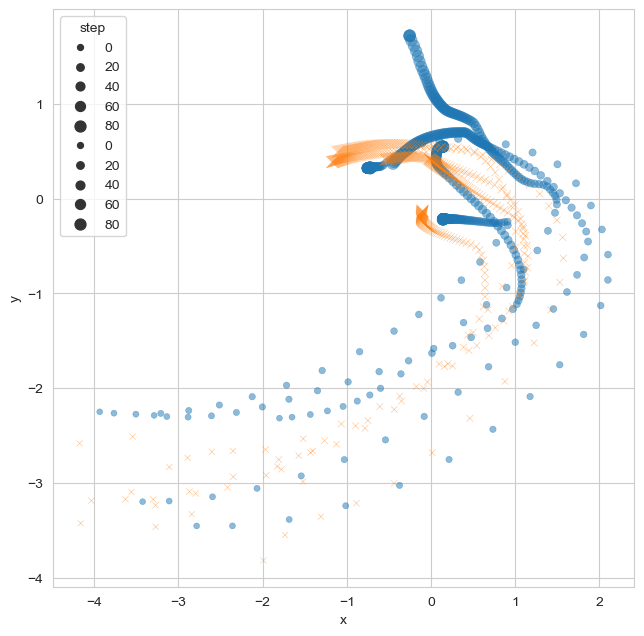

In [9]:


fig = plt.figure(figsize=(7.5,7.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
episode = 3

sns.scatterplot(data = df[df.episode==episode], x = 'x', y = 'y',ax=ax,edgecolor=None,alpha=.5,s=4,palette = sns.husl_palette(n_colors = 5),size = 'step')
sns.scatterplot(data = df[df.episode==episode], x = 'x_pred', y = 'y_pred',ax=ax,edgecolor=None,alpha=.5,s=4,palette = sns.husl_palette(n_colors = 5),size = 'step',marker = 'x')
#sns.scatterplot(data = df[df.episode>0], x = 'x_pred', y = 'y_pred',ax=ax,edgecolor=None,s=4)

#rect = matplotlib.patches.Rectangle((-3, -3), 6,6, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)


<Axes: xlabel='x_pred', ylabel='x'>

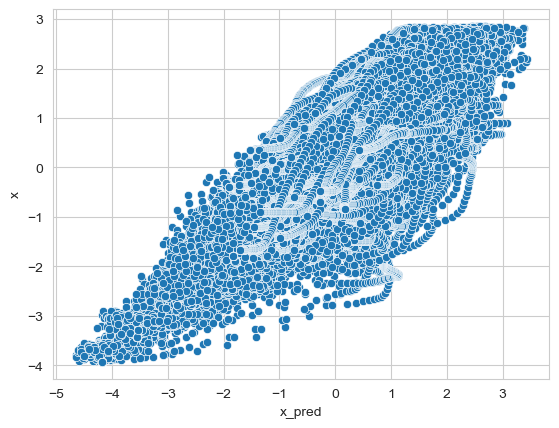

In [10]:
plt.figure()
sns.scatterplot(data = df, x = 'x_pred', y = 'x')

In [41]:
results[2]

-50.28554707995265

In [9]:
frames = []
env.reset()
for step in range(100):

        #env.mj_render()
        o = env.get_obs()
        a =np.array(torch.normal(mean=1, std=0.1,size=[39]))
        next_o, r, done, ifo = env.step(a)
        frames.append(env.sim.renderer.render_offscreen())
env.close()

In [6]:
pixels.shape

(480, 640, 3)

In [10]:
import cv2
import numpy as np

def create_video_from_frames(frames, output_path, fps=30):
    """
    Creates a video from a list of pixel arrays (frames).

    Args:
        frames (list of numpy.ndarray): A list of pixel arrays representing the frames of the video.
                                         Each array should have shape (height, width, 3) for color images
                                         or (height, width) for grayscale images.
        output_path (str): The path to save the output video file (e.g., "output.mp4").
        fps (int): Frames per second of the video.
    """
    if not frames:
        raise ValueError("The list of frames cannot be empty.")

    height, width = frames[0].shape[:2]
    is_color = len(frames[0].shape) == 3

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), is_color)

    for frame in frames:
        # Ensure the frame has the correct data type (uint8)
        frame = frame.astype(np.uint8)
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved to {output_path}")


# frames = []
# for i in range(100):
#     frame = np.random.randint(0, 256, size=(240, 320, 3), dtype=np.uint8)
#     frames.append(frame)

output_video_path = "example_video.mp4"
create_video_from_frames(frames, output_video_path, fps=30)

Video saved to example_video.mp4
